# Exploratory Data Analysis of beverage companies in UK

### 1) Data Collection

In [1]:
# list of libraries for this project
!pip3 install requests
import requests
import pprint as pp
import datetime
from datetime import date 
from datetime import datetime
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### 1.1) Function to call the API for retrieving JSON

In [2]:
def call_api_with(url_extension):
    your_company_house_api_key ="35868f3c-60c5-4659-8019-d44ff259f8c6"

    login_headers = {"Authorization":your_company_house_api_key}
    url = f"https://api.companieshouse.gov.uk/{url_extension}"
    # above: could be eg. https://api.companieshouse.gov.uk/search/companies?q=shop&items_per_page=1
    print(f'requesting: {url}') 
    # above, optional: printing, so that you see visually how many calls you are making
    res = requests.get(url, headers=login_headers) #, verify=False)
    return res.json()

In [3]:
# test to get one company
def get_one_test_company_or_error():
    url = f"search/companies?q=shop&items_per_page=1"
    return call_api_with(url)

#### 1.2) Function to search companies with specific SIC Codes

In [4]:
def search_for_companies_with_query(sic_codes, number_of_companies = 100):
    # for simplicity round up the number of returned companies to the nearest hundred. eg. 130 becomes 200
    page_size = 100
    number_of_pages = math.ceil(number_of_companies / page_size) # round up
    companies = []
    for page_index in range(0, number_of_pages):
        url = f"advanced-search/companies?sic_codes={sic_codes}&items_per_page={page_size}&index_start={page_index*page_size}"
        companies += call_api_with(url).get('items', [])
    return companies

#### 1.3) Function to get company data based on company number

In [5]:
def data_for_company(company_number):
    url = f"company/{company_number}"
    return call_api_with(url)

#### 1.4) Function to get detailed info about companies

In [6]:
def detailed_info_about_companies_with_ids(companies_numbers):
    results = []
    for company_number in companies_numbers:
        results.append(data_for_company(company_number))
    return results

#### 1.5) Combined function to retrieve final data

In [7]:
def detailed_info_about_companies_with_name(name, how_many = 10):
    # eg. unless otherwise stated, just grab 10 companies detailed info
    companies_basic_info = search_for_companies_with_query(name, how_many)
    companies_ids = [company['company_number'] for company in companies_basic_info]
    companies = detailed_info_about_companies_with_ids(companies_ids[:how_many])
    return companies

### 2) Data Processing

#### 2.1) Get data with 'detailed_info_about_companies_with_name'

Please note that the below code has been commented since it might take some time to run the code. The data extracted from the API was converted to a dataframe, concatenated, and then downloaded in a csv file after running the below codes.

In [8]:
#grape_wine = detailed_info_about_companies_with_name('11020', how_many=1000)
#cider = detailed_info_about_companies_with_name('11030', how_many=1000)
#fermented_beverage = detailed_info_about_companies_with_name('11040', how_many=1000)
#beer = detailed_info_about_companies_with_name('11050', how_many=1000)
#malt = detailed_info_about_companies_with_name('11060', how_many=1000)

#### 2.2) Convert data into dataframe and concat all the dataframes

In [9]:
#def convert_to_dataframe(df):
 #   df = pd.DataFrame(df)
  #  return df

#convert_to_dataframe(grape_wine)
#convert_to_dataframe(cider)
#convert_to_dataframe(fermented_beverage)
#convert_to_dataframe(beer)
#convert_to_dataframe(malt)

In [10]:
#def concat_data(data1,data2,data3,data4,data5):
 #   df = pd.concat(data1,data2,data3,data4,data5)
  #  return df

In [11]:
#final_data = concat_data([grape_wine,cider,fermented_beverage,beer,malt])

#### 2.3) Download the data in a csv file format

In [12]:
#def convert_to_csv_and_read(data):
 #   from IPython.display import FileLink
  #  df = pd.DataFrame(data)
    
    # Save DataFrame to CSV file
      # csv_filename = 'UK Beverage Companies_API.csv'
      # df.to_csv(csv_filename, index=False)
    # Display a download link for the CSV file
      # FileLink(csv_filename)

# Business Question 1: "What is the current status of the overall beverage companies?"

### Business Question 1: Code:

#### 1) Read the data

In [13]:
data = pd.read_csv('UK Beverage Companies_API.csv')

#### 2) Function to convert json strings to dataframe
Note: Certain columns such as 'links' and 'accounts' have dictionaries as row entries. This functions converts the json string (dictionaries) into dataframe and joins to the entire dataset

In [14]:
from ast import literal_eval

def safe_eval(value):
    try:
        return literal_eval(value)
    except (ValueError, SyntaxError):
        return {}

def json_to_dataframe(dataframe, column):
    column_df = dataframe[column]
    column_df = pd.DataFrame(column_df)
    column_df[column] = column_df[column].apply(safe_eval)
    column_df = pd.concat([column_df.drop([column], axis=1), column_df[column].apply(pd.Series)], axis=1)
    return column_df

In [15]:
## Convert json strings to columns in the dataset (This is specifically to extract cities from the address)

registered_office_address = json_to_dataframe(data,'registered_office_address')

In [16]:
## Join the columns to the entire dataset

data = data.join(registered_office_address)

#### 3) Function to add beverage tags based on SIC_Codes

In [17]:
def tag_based_on_sic(sic_code):
    if '11020' in sic_code:
        return 'Grape_wine'
    elif '11030' in sic_code:
        return 'Cider'
    elif '11040' in sic_code:
        return 'Fermented_beverage'
    elif '11050' in sic_code:
        return 'Beer'
    elif '11060' in sic_code:
        return 'Malt'
    else:
        return "NA"

data['Beverage tag'] = data['sic_codes'].apply(tag_based_on_sic)

#### 4) Function to perform groupby operation for visualization creation 

In [18]:
def group_by_function(df,column1,column2,column3):
    data = df.groupby([column1,column2,column3]).size().reset_index(name='count')
    return data

In [19]:
company_status_count = group_by_function(data,'Beverage tag','company_status','jurisdiction')

In [20]:
## Creating a new column 'year_of_cessation' to identify when a company was dissolved
data['year_of_cessation'] = pd.to_datetime(data['date_of_cessation']).dt.year
cessation_date_count = group_by_function(data,'Beverage tag','company_status','year_of_cessation')

## Note: It can be observed from the data that only those companies with a dissolved status have a cessation date 

### Business Question 1: Mini-report and visualisation:

#### 5) Function to create side by side visualization

In [21]:
def plot_bar_scatter_plot(bar_data,scatter_date,column1,column2,column3,column4):
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Side-by-side bar graph
    bar_data_graph = bar_data.pivot_table(index=column1, columns=column2, values=column3, aggfunc='sum', fill_value=0)
    bar_data_graph.plot(kind='bar', stacked=False, ax=axes[0])

    # Add labels, title, and legend for the bar graph
    axes[0].set_xlabel(column1)
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
    axes[0].set_ylabel(column3)
    axes[0].set_title('Side-by-Side Bar Graph between {} & {}'.format(column1, column2))
    axes[0].legend(title=column2)

    # Scatter plot
    for tag in scatter_date[column1].unique():
        subset = scatter_date[scatter_date[column1] == tag]
        axes[1].scatter(subset[column4], subset[column3], label=tag, s=100)

    # Add labels, title, and legend for the scatter plot
    axes[1].set_xlabel(column4)
    axes[1].set_ylabel(column3)
    axes[1].set_title('Scatter Plot of dissolved companies between {} & {}'.format(column4, column1))
    axes[1].legend(title=column1, bbox_to_anchor=(1.05, 1), loc='upper left')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

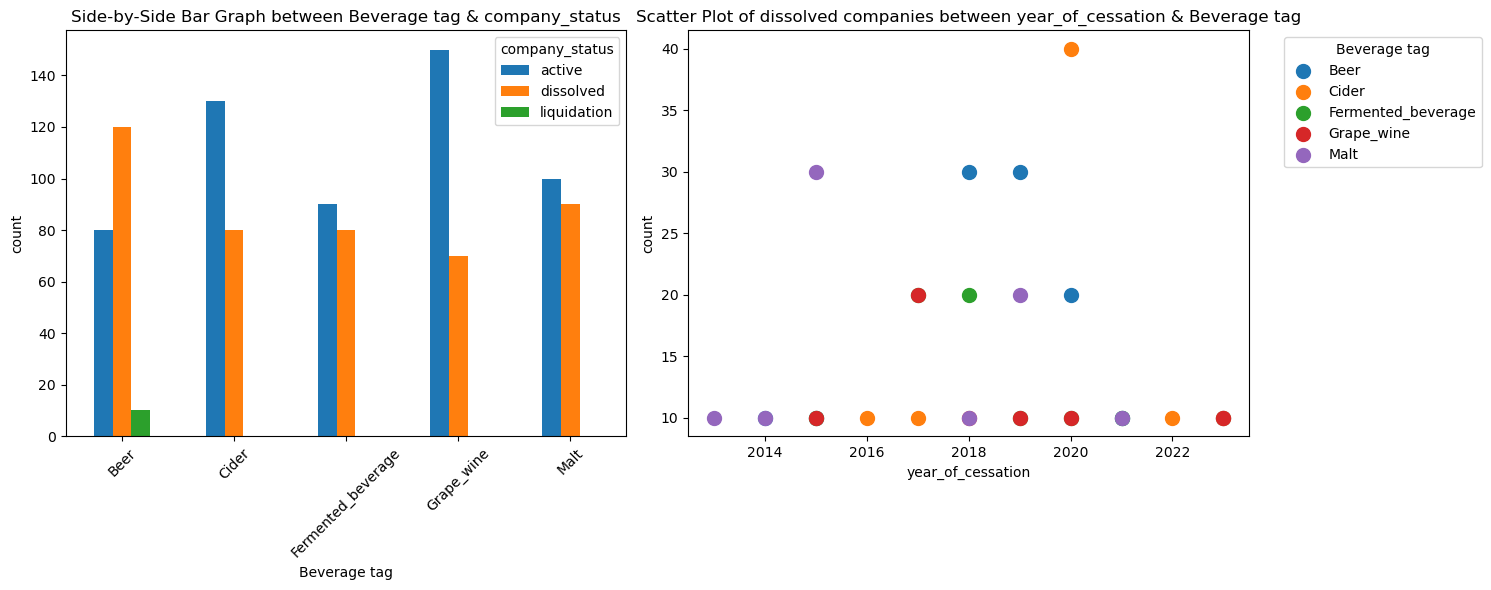

In [22]:
plot_bar_scatter_plot(company_status_count,cessation_date_count,'Beverage tag','company_status','count','year_of_cessation')

**Mini Report:**  
To assess the status of the beverage industry, five key beverage sectors were analysed: grape wine, cider, fermented beverage, beer, and malt. Leveraging data from the Companies House public API, the goal was to provide insights into the overall health of the beverage companies.  

_1) Active vs. Dissolved Companies:_
For grape wine, cider, fermented beverage, and malt, the number of active companies either surpassed or closely matched the count of dissolved companies. This indicates a stable or growing market presence for these sectors. However, the beer sector exhibited an opposite trend. The number of dissolved and liquidated companies outpaced the count of active ones, suggesting a more challenging landscape for beer companies.  
_2) Time-period Analysis:_
To further investigate into the dynamics of dissolved companies, a scatter plot was generated between years of cessation and beverage companies. A notable surge in the number of dissolved companies was observed between 2018 and 2020 indicating a potential industry-wide shift affected the companies in various segments during this period.  

This analysis served as a foundation for a more targeted research and decision-making within the beverage industry, offering stakeholders a nuanced understanding of the challenges and opportunities within their respective sectors.

# Business Question 2: "What is the geographical trend of dissolved and active beverage companies in the UK?" 

### Business Question 2: Code:

#### 1) Import library for map creation

In [23]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [24]:
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime

#### 2) Create dataset for plotting heatmap

In [25]:
heatmap_data = group_by_function(data,'Beverage tag','company_status','jurisdiction')

#### 3) Function to add latitude & longitude to heatmap_data

In [26]:
def geolocation(geo_column):
    if 'england-wales' in geo_column:
        return '52.654257, -1.402561'
    elif 'wales' in geo_column:
        return '52.274541, -3.704038'
    elif 'scotland' in geo_column:
        return '55.800281, -3.661028'
    else: return ['NA']

heatmap_data['Geolocation'] = heatmap_data['jurisdiction'].apply(geolocation)

In [27]:
## Split the latitude and longitude in two different columns

heatmap_data[['latitude','longitude']] = heatmap_data['Geolocation'].str.split(", ",expand=True).astype(float)

#### 4) Function to identify countries within UK with active/dissolved highest beverage companies

In [28]:
def heatmap_visual(df):
    ## Create a base map centered around the UK
    uk_map = folium.Map(location=[52.063859, -1.718552], zoom_start=5)

    ## Create a list of points (latitude, longitude, weight) for HeatMap
    heat_data = heatmap_data[['latitude', 'longitude', 'count']].values.tolist()

    ## Add HeatMap layer to the map
    HeatMap(heat_data).add_to(uk_map)
    
    ## Save the map as an HTML file or display it
    uk_map.save('uk_heatmap.html')
    return uk_map

In [29]:
heatmap_visual(heatmap_data)

#### 5) Function to create city data for the country with highest active/dissolved beverage comanies

In [30]:
def city_data_for_highest_country(df,country):
    highest_country_data = df[df['jurisdiction']==country]
    highest_country_dissolved_company = highest_country_data[highest_country_data['company_status']=='dissolved']
    highest_country_active_company = highest_country_data[highest_country_data['company_status']=='active']
    return highest_country_dissolved_company,highest_country_active_company

In [31]:
dissolved_company_data, active_company_data = city_data_for_highest_country(data,'england-wales')

### Business Question 2: Mini-report and visualisation:

#### 6) Function to identify cities in the country with highest active/dissolved beverage companies

In [32]:
def heatmap_and_localities(dissolved,active):
    from folium import IFrame
    import matplotlib.pyplot as plt
    import base64

    # Create subplots for the line graphs
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    # Plot for dissolved companies
    plot_dissolved = dissolved['locality'].value_counts().head(10)
    axes[0].plot(plot_dissolved.index, plot_dissolved.values, marker='o', linestyle='-', color='r')
    axes[0].set_xlabel('Cities')
    axes[0].set_ylabel('Count of Dissolved Companies')
    axes[0].set_title('Top 10 Cities - Dissolved Companies')
    axes[0].tick_params(axis='x', rotation=45)  

    # Plot for active companies
    plot_active = active['locality'].value_counts().head(10)
    axes[1].plot(plot_active.index, plot_active.values, marker='o', linestyle='-', color='g')
    axes[1].set_xlabel('Cities')
    axes[1].set_ylabel('Count of Active Companies')
    axes[1].set_title('Top 10 Cities - Active Companies')
    axes[1].tick_params(axis='x', rotation=45)  

    # Save the Matplotlib plot as an image
    plt.savefig('line_graphs.png')

    # Encode the image to base64
    encoded_image = base64.b64encode(open('line_graphs.png', 'rb').read()).decode()

    # Create an HTML string with the embedded image
    html = f'<img src="data:image/png;base64,{encoded_image}" width="800" height="600">'

    # Create an IFrame to embed the HTML content
    line_graph_iframe = IFrame(html, width=800, height=600)

    # Add the IFrame to a Folium Popup
    folium.Popup(line_graph_iframe, max_width=800).add_to(heatmap_visual(heatmap_data))

    # Save the map with Popup
    heatmap_visual(heatmap_data).save('uk_map_with_line_graphs.html')

    # Display the map
    return heatmap_visual(heatmap_data)

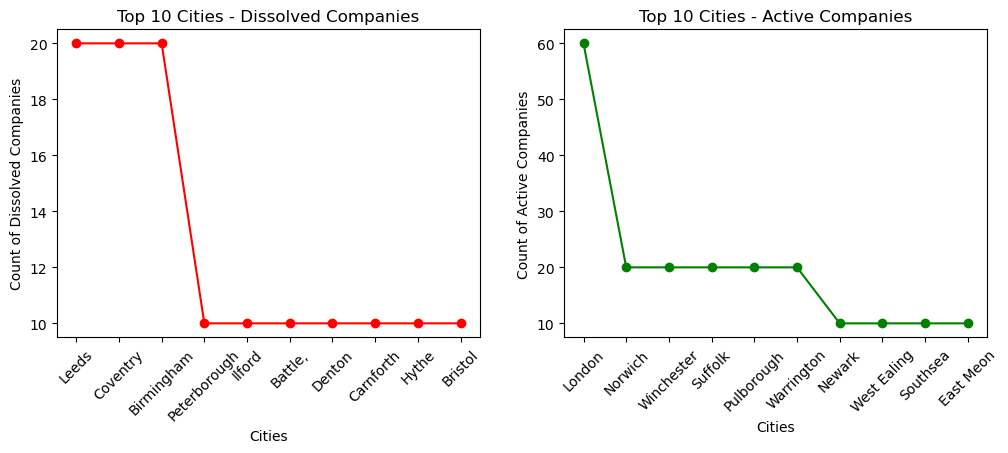

In [33]:
heatmap_and_localities(dissolved_company_data,active_company_data)

**Mini Report:**  
In addition to examining the temporal trends of dissolved beverage companies, understanding the spatial distribution of both dissolved and active companies is crucial. This approach facilitates the development of targeted, market-driven strategies. The heatmap analysis confirms that England stands out as the predominant hub for beverage companies, surpassing both Wales and Scotland, underscoring its appeal as a prime location for stakeholders to establish and operate their services. Central England (Coventry and Birmingham) and Northern England (Leeds) exhibit a notable concentration of dissolved beverage companies suggesting unique challenges or market dynamics in these regions that may have contributed to the cessation of businesses. On the other hand, southern England (London) stands out as a hotspot for active beverage companies. The thriving nature of the industry in London could be attributed to factors such as high tourism, providing a conducive environment for beverage companies to flourish.  

Understanding the geographical distribution of beverage companies allows stakeholders to tailor their strategies based on regional dynamics. For instance, in regions with a high incidence of dissolved companies, there may be opportunities for market re-entry or targeted support for new beverages. Conversely, areas with a concentration of active companies, such as London, represent potential growth markets.